Daten einlesen, Zielvariable festlegen und X-Daten normalisieren

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\ml_algorithmus_finden.xlsx"

# Excel-Datei einlesen
try:
    # Direkt die Datei einlesen (erstes Tabellenblatt standardmäßig)
    df = pd.read_excel(file_path)

    # Informationen anzeigen
    print("\nErste Zeilen der Tabelle:")
    print(df.head())  # Zeigt die ersten 5 Zeilen an

    print("\nInformationen über die Tabelle:")
    print(df.info())  # Struktur der Tabelle

    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    X = df.drop(columns=['Verletzungsstatus'])  # Entferne die Zielvariable aus den Features

    # Skalierung der Features (X) mit StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # Normiert X auf den Standardbereich (Mittelwert = 0, Std = 1)

    # Ausgabe nach Skalierung (optional)
    print("\nBeispiel nach Skalierung (erste Zeilen):")
    print(pd.DataFrame(X_scaled, columns=X.columns).head())

except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfen Sie den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")


Modelle vergleichen mit Standardeinstellungen

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler

def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10):
    """Führt repeated k-fold cross-validation durch und berechnet die Metriken."""
    # Repeated Stratified K-Fold
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    # Metriken definieren
    accuracy_train = []
    accuracy_test = []
    f1 = []
    recall = []  
    roc_auc = []

    for train_index, test_index in rkf.split(X, y):
        # Splitte die Daten in Trainings- und Testdaten
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Trainiere das Modell
        model.fit(X_train, y_train)

        # Vorhersagen für Trainings- und Testdaten
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Berechne die Metriken
        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        f1.append(f1_score(y_test, y_test_pred))
        recall.append(recall_score(y_test, y_test_pred))  
        roc_auc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    # Durchschnittswerte berechnen
    return {
        "Train Accuracy": np.mean(accuracy_train),
        "Test Accuracy": np.mean(accuracy_test),
        "F1-Score": np.mean(f1),
        "Recall": np.mean(recall), 
        "ROC-AUC": np.mean(roc_auc),
    }

# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Vergleich_links_rechts_INV_UNINV\sortierte_Basistabelle.xlsx"

# Excel-Datei einlesen
try:
    # Direkt die Datei einlesen (erstes Tabellenblatt standardmäßig)
    df = pd.read_excel(file_path)

    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    X = df.drop(columns=['Verletzungsstatus'])  # Entferne die Zielvariable aus den Features

    # Skalierung der Features (X) mit StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # Normiert X auf den Standardbereich (Mittelwert = 0, Std = 1)

    # Modelle definieren
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
        "LightGBM": LGBMClassifier(verbose=-1,random_state=42),
        "SVC": SVC(probability=True, random_state=42),
        "k-Nearest Neighbors": KNeighborsClassifier(),
        "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42),
        "Gaussian Naive Bayes": GaussianNB(),
        "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
        "Bagging Classifier": BaggingClassifier(random_state=42),
        "Extra Trees": ExtraTreesClassifier(random_state=42),
    }

    # Ergebnisse speichern
    results = []

    # Validierung jedes Modells
    for model_name, model in models.items():
        print(f"Modell wird validiert: {model_name}")
        metrics = repeated_k_fold(model, X_scaled, y)  # Verwende X_scaled statt X
        results.append({"Model": model_name, **metrics})

    # Ergebnisse in DataFrame konvertieren und sortieren
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="ROC-AUC", ascending=False)

    # Ergebnisse anzeigen
    print("\nErgebnisse der Modelle:")
    print(results_df)

except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfen Sie den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")


Modell wird validiert: Logistic Regression
Modell wird validiert: Decision Tree
Modell wird validiert: Random Forest
Modell wird validiert: Gradient Boosting
Modell wird validiert: XGBoost


C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:01:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:01:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:01:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarn

Modell wird validiert: LightGBM
[LightGBM] [Info] Number of positive: 52, number of negative: 42
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3380
[LightGBM] [Info] Number of data points in the train set: 94, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553191 -> initscore=0.213574
[LightGBM] [Info] Start training from score 0.213574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\boehmer\AppData\Local\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Varia

Modell wird validiert: Bagging Classifier
Modell wird validiert: Extra Trees

Ergebnisse der Modelle:
                              Model  Train Accuracy  Test Accuracy  F1-Score  \
0               Logistic Regression        0.992376       0.791739  0.808561   
3                 Gradient Boosting        1.000000       0.792790  0.810489   
13                      Extra Trees        1.000000       0.789239  0.817600   
6                               SVC        0.946206       0.786413  0.818121   
4                           XGBoost        1.000000       0.775000  0.795767   
5                          LightGBM        1.000000       0.769348  0.788978   
2                     Random Forest        1.000000       0.802210  0.830249   
12               Bagging Classifier        0.986004       0.764058  0.777338   
8                    MLP Classifier        1.000000       0.765435  0.788704   
9              Gaussian Naive Bayes        0.842387       0.748551  0.778506   
7               k-

In [ ]:
results_df

Auto ML mit TPOT

In [ ]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Daten einlesen
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\ml_algorithmus_finden.xlsx"
df = pd.read_excel(file_path)

# Zielvariable (y) und Features (X) extrahieren
y = df['Verletzungsstatus']
X = df.drop(columns=['Verletzungsstatus'])

# Skalierung der Features (X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Trainings- und Testdaten splitten
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# TPOTClassifier erstellen und anpassen
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42)

# Modell mit dem Trainingsdatensatz optimieren
tpot.fit(X_train, y_train)

# Beste Lösung ausgeben
print("Beste Lösung:", tpot.fitted_pipeline_)

# Evaluation des besten Modells auf den Testdaten
print(f"Test Accuracy: {tpot.score(X_test, y_test)}")

# Optional: Export des besten Modells als Python-Code
tpot.export('best_model.py')


Einzelnes Modell validieren

Modell wird validiert: Extra Trees

Ergebnisse der Modelle:
         Model  Train Accuracy  Test Accuracy  F1-Score    Recall   ROC-AUC
0  Extra Trees        0.997861       0.816377  0.838826  0.864615  0.916224


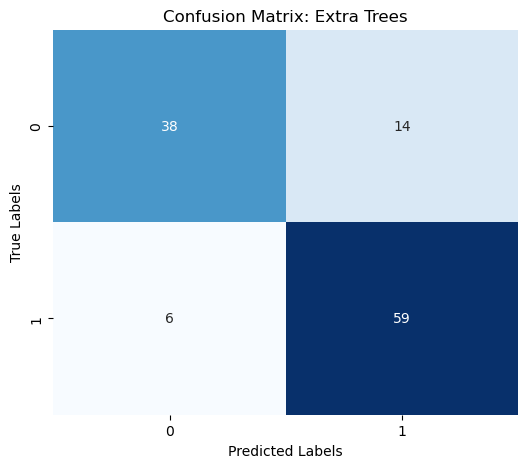

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def repeated_k_fold(model, X, y, n_splits=5, n_repeats=10):
    """Führt repeated k-fold cross-validation durch und berechnet die Metriken."""
    # Repeated Stratified K-Fold
    rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    # Metriken definieren
    accuracy_train = []
    accuracy_test = []
    f1 = []
    recall = []
    roc_auc = []

    for train_index, test_index in rkf.split(X, y):
        # Splitte die Daten in Trainings- und Testdaten
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Trainiere das Modell
        model.fit(X_train, y_train)

        # Vorhersagen für Trainings- und Testdaten
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Berechne die Metriken
        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        f1.append(f1_score(y_test, y_test_pred))
        recall.append(recall_score(y_test, y_test_pred))
        roc_auc.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    # Durchschnittswerte berechnen
    return {
        "Train Accuracy": np.mean(accuracy_train),
        "Test Accuracy": np.mean(accuracy_test),
        "F1-Score": np.mean(f1),
        "Recall": np.mean(recall),
        "ROC-AUC": np.mean(roc_auc),
    }


# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Vergleich_links_rechts_INV_UNINV\sortierte_Basistabelle.xlsx"

# Excel-Datei einlesen
try:
    # Direkt die Datei einlesen (erstes Tabellenblatt standardmäßig)
    df = pd.read_excel(file_path)

    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    X = df.drop(columns=['Verletzungsstatus'])  # Entferne die Zielvariable aus den Features

    # Skalierung der Features (X) mit StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # Normiert X auf den Standardbereich (Mittelwert = 0, Std = 1)

    # Modelle definieren
    models = {
    "Extra Trees": ExtraTreesClassifier(
        bootstrap=False, 
        criterion="gini", 
        max_features=0.3, 
        min_samples_leaf=4, 
        min_samples_split=9, 
        n_estimators=100,
        random_state=42
    ),}



    # Ergebnisse speichern
    results = []

    # Validierung jedes Modells
    for model_name, model in models.items():
        print(f"Modell wird validiert: {model_name}")
        metrics = repeated_k_fold(model, X_scaled, y)  # Verwende X_scaled statt X
        results.append({"Model": model_name, **metrics})

    # Ergebnisse in DataFrame konvertieren und sortieren
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="ROC-AUC", ascending=False)

    # Ergebnisse anzeigen
    print("\nErgebnisse der Modelle:")
    print(results_df)

    for model_name, model in models.items():
        
        metrics = repeated_k_fold(model, X_scaled, y)  # Verwende X_scaled statt X
        results.append({"Model": model_name, **metrics})
    
        # Confusion Matrix berechnen (für gesamtes Dataset)
        y_pred = cross_val_predict(model, X_scaled, y, cv=5, method='predict')
        cm = confusion_matrix(y, y_pred)
    
        # Confusion Matrix visualisieren
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                    xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix: {model_name}')
    
        # Bild speichern (optional)
        #plt.savefig(f'output/confusion_matrix_{model_name.replace(" ", "_")}.png')
    
        # Bild anzeigen
        plt.show()


except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfen Sie den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")


In [ ]:
results_df

Grid Search für ein ausgewähltes Modell

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import ExtraTreesClassifier
    

# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\ml_algorithmus_finden.xlsx"

# Excel-Datei einlesen
try:
    # Direkt die Datei einlesen (erstes Tabellenblatt standardmäßig)
    df = pd.read_excel(file_path)

    # Zielvariable (y) und Features (X) extrahieren
    y = df['Verletzungsstatus']
    X = df.drop(columns=['Verletzungsstatus'])  # Entferne die Zielvariable aus den Features

    # Skalierung der Features (X) mit StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # Normiert X auf den Standardbereich (Mittelwert = 0, Std = 1)

    # Ausgabe nach Skalierung (optional)
    print("\nBeispiel nach Skalierung (erste Zeilen):")
    print(pd.DataFrame(X_scaled, columns=X.columns).head())
    
    # Train-Test-Split durchführen (80% Training, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Modell initialisieren
    model = ExtraTreesClassifier(random_state=42)
    
    # Parameterbereich für GridSearch definieren
    param_grid = {
        'n_estimators': [50, 100, 200, 300, 500],
        'max_features': ['auto', 'sqrt', 'log2', 0.1, 0.3],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5, 10],
        'bootstrap': [True, False]
    }
    
    # GridSearchCV initialisieren
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=5, n_jobs=-1, scoring='roc_auc', verbose=1)
    
    # Führe GridSearchCV aus auf dem Trainingsdatensatz
    grid_search.fit(X_train, y_train)
    
    # Beste Parameter und beste Leistung anzeigen
    print(f"Beste Parameter: {grid_search.best_params_}")
    print(f"Beste ROC-AUC: {grid_search.best_score_}")
    
    # Optional: Testdaten mit dem besten Modell evaluieren
    best_model = grid_search.best_estimator_
    
    # Vorhersage und Bewertung auf dem Testdatensatz
    from sklearn.metrics import roc_auc_score
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_test_prob)
    
    print(f"ROC-AUC auf den Testdaten: {roc_auc}")
    

except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Bitte überprüfen Sie den Pfad.")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")


Feature Importance berechnen

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Pfad zur Datei
file_path = r"K:\Team\Böhmer_Michael\TSA\ML\ml_algorithmus_finden.xlsx"

# Excel-Datei einlesen
df = pd.read_excel(file_path)

# Zielvariable (y) und Features (X) extrahieren
y = df['Verletzungsstatus']
X = df.drop(columns=['Verletzungsstatus'])  # Entferne die Zielvariable aus den Features

# Skalierung der Features (X) mit StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normiert X auf den Standardbereich (Mittelwert = 0, Std = 1)

# Repeated Stratified K-Fold Cross-Validation
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# Feature Importance speichern
feature_importances_list = []

# K-Fold Cross-Validation durchführen
for train_index, test_index in rkf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modell mit den spezifischen Hyperparametern initialisieren und trainieren
    model = ExtraTreesClassifier(
        bootstrap=True, 
        criterion="entropy", 
        max_depth=None, 
        max_features=0.3, 
        min_samples_leaf=1, 
        min_samples_split=5, 
        n_estimators=100,
        random_state=42
    )
    
    model.fit(X_train, y_train)

    # Feature Importance für den aktuellen Fold speichern
    feature_importances_list.append(model.feature_importances_)

# Durchschnitt der Feature-Importances über alle Folds berechnen
average_importances = np.mean(feature_importances_list, axis=0)

# Feature Importance mit den Feature-Namen anzeigen
indices = average_importances.argsort()[::-1]  # Absteigend sortieren
print("Feature Importance (durchschnittlich über alle Folds):")
for i in indices:
    print(f"Feature {X.columns[i]}: {average_importances[i]:.4f}")

# Visualisierung: Balkendiagramm erstellen
plt.figure(figsize=(14, 30))  # Größe des Diagramms erhöhen

# Balkenbreite und Abstand anpassen
sns.barplot(x=average_importances[indices], y=X.columns[indices], orient='h', palette='viridis', width=0.8, hue = None)

# Titel und Achsenbeschriftungen anpassen
plt.title('Feature Importance (Durchschnitt über alle Folds)', fontsize=16)
plt.xlabel('Wichtigkeit', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Schriftgröße der Achsenbeschriftungen anpassen
plt.xticks(fontsize=12)  # Schriftgröße für x-Achse
plt.yticks(fontsize=12)  # Schriftgröße für y-Achse

# Diagramm anzeigen
plt.show()



In [21]:
# Korrelationsmatrix berechnen
correlation_matrix = df.drop(columns=['Verletzungsstatus']).corr()

# Starke Korrelationen anzeigen
#print("Korrelationsmatrix:")
#print(correlation_matrix)

# Optional: Visualisierung der Matrix (wenn matplotlib oder seaborn verfügbar ist)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelationsmatrix")
plt.show()


In [23]:
# Bibliotheken importieren
import seaborn as sns
import matplotlib.pyplot as plt

# Pfad für die Speicherung
save_path_svg = r"K:\Team\Böhmer_Michael\TSA\ML\grafik\korrelationsmatrix.svg"
save_path_png = r"K:\Team\Böhmer_Michael\TSA\ML\grafik\korrelationsmatrix.png"

# Grafik erstellen
plt.figure(figsize=(80, 80))  # Sehr große Figur für Lesbarkeit
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 6},  # Kleinere Schrift für Werte
    cbar_kws={"shrink": 0.5}  # Farblegende etwas kleiner machen
)
plt.title("Korrelationsmatrix", fontsize=20)
plt.xticks(fontsize=8, rotation=45)  # Drehung der Achsenbeschriftungen
plt.yticks(fontsize=8)

# SVG speichern
plt.savefig(save_path_svg, format="svg", bbox_inches="tight")  # SVG-Format für verlustfreie Skalierung

# Optionale PNG-Speicherung mit hoher DPI
plt.savefig(save_path_png, format="png", dpi=300, bbox_inches="tight")  # Hohe Auflösung für PNG

plt.close()

print(f"Die SVG-Grafik wurde gespeichert unter: {save_path_svg}")
print(f"Die PNG-Grafik wurde gespeichert unter: {save_path_png}")


Die SVG-Grafik wurde gespeichert unter: K:\Team\Böhmer_Michael\TSA\ML\grafik\korrelationsmatrix.svg
Die PNG-Grafik wurde gespeichert unter: K:\Team\Böhmer_Michael\TSA\ML\grafik\korrelationsmatrix.png


In [5]:
# Stark korrelierte Features identifizieren
threshold = 0.8  # Schwellenwert für starke Korrelation
highly_correlated_pairs = []

for i in range(correlation_matrix.shape[0]):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_i = correlation_matrix.index[i]
            feature_j = correlation_matrix.index[j]
            highly_correlated_pairs.append((feature_i, feature_j, correlation_matrix.iloc[i, j]))

print("Stark korrelierte Variablen:")
for pair in highly_correlated_pairs:
    print(f"{pair[0]} und {pair[1]} mit Korrelationskoeffizient {pair[2]:.2f}")


Stark korrelierte Variablen:
CMJ_Net Impulse und CMJ_Jump Height flighttime mit Korrelationskoeffizient 0.93
CMJ_Jump Height impulse und CMJ_Vertical Takeoff velocity mit Korrelationskoeffizient 0.88
CMJ_Rel. peak loading force left und CMJ_Rel. peak loading force mit Korrelationskoeffizient 0.87
CMJ_Rel. peak loading force right und CMJ_Rel. peak loading force mit Korrelationskoeffizient 0.88
CMJ_RSI (impulse) und CMJ_Net Impulse mit Korrelationskoeffizient 0.81
CMJ_Rel. Peak Power und CMJ_Jump Height flighttime mit Korrelationskoeffizient 0.91
CMJ_Rel. Peak Power und CMJ_Net Impulse mit Korrelationskoeffizient 0.91
CMJ_Rel. Peak Power und CMJ_RSI (impulse) mit Korrelationskoeffizient 0.82
CMJ_Rel. Peak Power left und CMJ_Jump Height flighttime mit Korrelationskoeffizient 0.88
CMJ_Rel. Peak Power left und CMJ_Net Impulse mit Korrelationskoeffizient 0.88
CMJ_Rel. Peak Power left und CMJ_Rel. Peak Power mit Korrelationskoeffizient 0.95
CMJ_Rel. Peak Power right und CMJ_Jump Height fligh

In [1]:
!git add ML_Vorlage.ipynb
!git commit -m "Ergänzung Modellbewertung Recall"
!git push origin master

[master d0d3236] ErgÃ¤nzung Modellbewertung allgemein
 1 file changed, 37 insertions(+), 1 deletion(-)


To https://github.com/michi1308/ML_jupyter_notebook.git
   064fb5c..d0d3236  master -> master
